# imgAN

##### a project on generating images using 

## General Adversarial Networks (GANs)

by Yash Bhardwaj

Notebook version : 1



### Introduction to Generative Modelling
Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: **Generative modeling**

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

To get a sense of the power of Generative models, visit [thispersondoesnotexist.com](https://www.thispersondoesnotexist.com). Every time this page is refreshed, a new image of a non-existent person's face is generated in real time.


<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" /> 

[](https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png)

In [1]:
project_name = "imgAN"

In [2]:
!pip install rarfile --quiet
!pip install opendatasets --quiet

In [3]:
import os
import cv2
import opendatasets as od
from google.colab import files


import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm.notebook import tqdm

from IPython.display import Image

%matplotlib inline

## Downloading and Exploring the Dataset

Using the `opendatasets` library, download the required dataset.
`opendatasets` uses the Kaggle API to download datasets from Kaggle. Use Kaggle credentials to generate a `.json` file key which can be directly uploaded and used in colab.

In [4]:
dataset_url = "https://www.kaggle.com/greatgamedota/ffhq-face-data-set"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yashonkaggle
Your Kaggle Key: ··········


  0%|          | 0.00/1.97G [00:00<?, ?B/s]

100%|██████████| 1.97G/1.97G [01:00<00:00, 34.7MB/s]


In [5]:
DATA_DIR = "./ffhq-face-data-set" 
print(os.listdir(DATA_DIR))

['thumbnails128x128']


In [6]:
print(os.listdir(DATA_DIR+'/thumbnails128x128')[:10])
REAL_DIR = DATA_DIR+'/thumbnails128x128/'

['48174.png', '41602.png', '52919.png', '67792.png', '66685.png', '12738.png', '37178.png', '26210.png', '49359.png', '39120.png']


In [59]:
"""
FOR FETCHING DATA FROM GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive/')

!unzip -uq "/content/drive/MyDrive/Datasets/140K-real-fake-faces.zip" -d "/content/dataset"

DATA_DIR = "/content/dataset/real_vs_fake/real-vs-fake"
print(os.listdir(DATA_DIR))

print(os.listdir(DATA_DIR+'/train/fake')[:10])
"""

'\nFOR FETCHING DATA FROM GOOGLE DRIVE\n\nfrom google.colab import drive\ndrive.mount(\'/content/drive/\')\n\n!unzip -uq "/content/drive/MyDrive/Datasets/140K-real-fake-faces.zip" -d "/content/dataset"\n\nDATA_DIR = "/content/dataset/real_vs_fake/real-vs-fake"\nprint(os.listdir(DATA_DIR))\n\nprint(os.listdir(DATA_DIR+\'/train/fake\')[:10])\n'

In [39]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [40]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


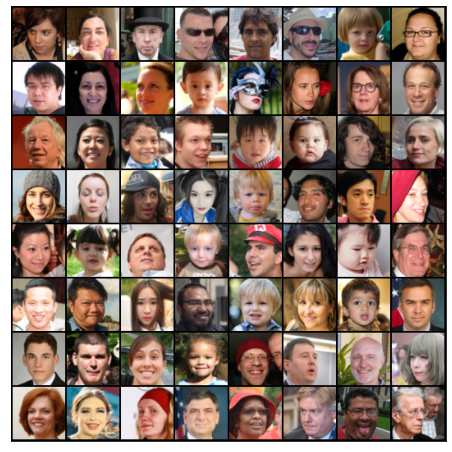

In [42]:
show_batch(train_dl)

## Using a GPU 
To seamlessly integrate and utilize a GPU (if available) helper functions `get_default_device` & `to_device` and a helper class `DeviceDataLoader` are defined to move our model & data to the GPU.

In [43]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [44]:
device = get_default_device()
device

device(type='cuda')

In [45]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif">

In [46]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we're using the Leaky ReLU activation for the discriminator.

<img style="width: 200px; height: 150px;" src = "https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png">

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [47]:
discriminator = to_device(discriminator, device)

## Generator Network
The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution).

<img src="https://i.imgur.com/DRvK546.gif">

In [48]:
latent_size = 128

In [49]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


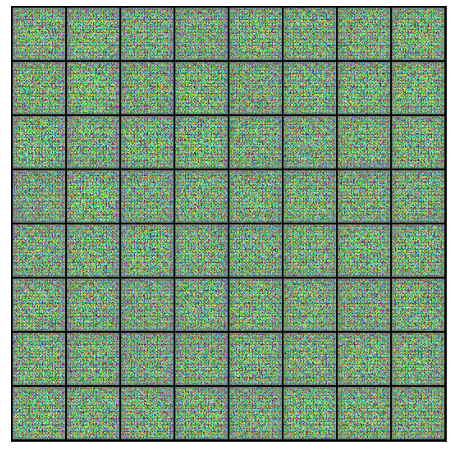

In [50]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [51]:
generator = to_device(generator, device)

In [52]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [53]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [54]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [55]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Complete Training Loop

<img src="https://i.imgur.com/6NMdO9u.png">

Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

In [73]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [57]:
# Training Hyperparameters

lr = 0.0002
epochs = 25

In [58]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/25], loss_g: 3.0847, loss_d: 0.3294, real_score: 0.8824, fake_score: 0.1594
Saving generated-images-0001.png



Epoch [2/25], loss_g: 5.9706, loss_d: 0.6682, real_score: 0.9020, fake_score: 0.3887
Saving generated-images-0002.png



Epoch [3/25], loss_g: 3.8605, loss_d: 0.3372, real_score: 0.9006, fake_score: 0.1891
Saving generated-images-0003.png



Epoch [4/25], loss_g: 5.6621, loss_d: 0.5283, real_score: 0.9571, fake_score: 0.3526
Saving generated-images-0004.png



Epoch [5/25], loss_g: 3.9818, loss_d: 0.4742, real_score: 0.9062, fake_score: 0.2671
Saving generated-images-0005.png



Epoch [6/25], loss_g: 5.2228, loss_d: 0.3375, real_score: 0.9425, fake_score: 0.2198
Saving generated-images-0006.png



Epoch [7/25], loss_g: 5.0703, loss_d: 0.4502, real_score: 0.9725, fake_score: 0.3237
Saving generated-images-0007.png



Epoch [8/25], loss_g: 4.0900, loss_d: 0.3186, real_score: 0.9367, fake_score: 0.1981
Saving generated-images-0008.png



Epoch [9/25], loss_g: 3.0138, loss_d: 0.8457, real_score: 0.6964, fake_score: 0.2661
Saving generated-images-0009.png



Epoch [10/25], loss_g: 4.1003, loss_d: 0.3246, real_score: 0.8384, fake_score: 0.1126
Saving generated-images-0010.png



Epoch [11/25], loss_g: 2.3020, loss_d: 0.6612, real_score: 0.6310, fake_score: 0.0804
Saving generated-images-0011.png



Epoch [12/25], loss_g: 9.2510, loss_d: 2.0864, real_score: 0.9963, fake_score: 0.7910
Saving generated-images-0012.png



Epoch [13/25], loss_g: 2.7819, loss_d: 0.2090, real_score: 0.8412, fake_score: 0.0240
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.3024, loss_d: 0.3312, real_score: 0.9707, fake_score: 0.2307
Saving generated-images-0014.png



Epoch [15/25], loss_g: 4.3899, loss_d: 0.1131, real_score: 0.9231, fake_score: 0.0285
Saving generated-images-0015.png



Epoch [16/25], loss_g: 3.5336, loss_d: 0.1764, real_score: 0.8956, fake_score: 0.0558
Saving generated-images-0016.png



Epoch [17/25], loss_g: 3.8129, loss_d: 0.1383, real_score: 0.9172, fake_score: 0.0446
Saving generated-images-0017.png



Epoch [18/25], loss_g: 3.5975, loss_d: 0.1711, real_score: 0.8993, fake_score: 0.0527
Saving generated-images-0018.png



Epoch [19/25], loss_g: 4.9289, loss_d: 0.5801, real_score: 0.9881, fake_score: 0.3663
Saving generated-images-0019.png



Epoch [20/25], loss_g: 3.5105, loss_d: 1.0815, real_score: 0.9137, fake_score: 0.5311
Saving generated-images-0020.png



Epoch [21/25], loss_g: 1.2129, loss_d: 2.2349, real_score: 0.1780, fake_score: 0.0077
Saving generated-images-0021.png



Epoch [22/25], loss_g: 2.6454, loss_d: 0.5209, real_score: 0.6774, fake_score: 0.0320
Saving generated-images-0022.png



Epoch [23/25], loss_g: 3.1003, loss_d: 0.1523, real_score: 0.8980, fake_score: 0.0355
Saving generated-images-0023.png



Epoch [24/25], loss_g: 5.0394, loss_d: 0.0643, real_score: 0.9751, fake_score: 0.0358
Saving generated-images-0024.png



Epoch [25/25], loss_g: 0.2854, loss_d: 1.3643, real_score: 0.3787, fake_score: 0.0519
Saving generated-images-0025.png


In [71]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

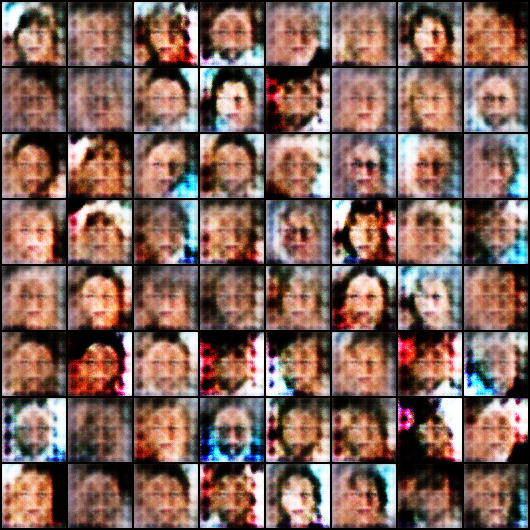

In [72]:
Image('./generated/generated-images-0001.png')

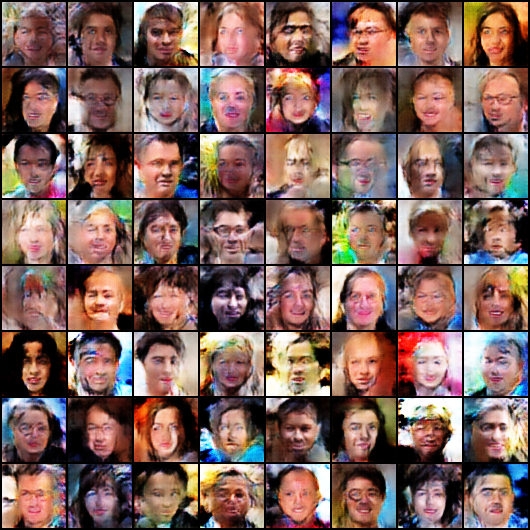

In [62]:
Image('./generated/generated-images-0005.png')

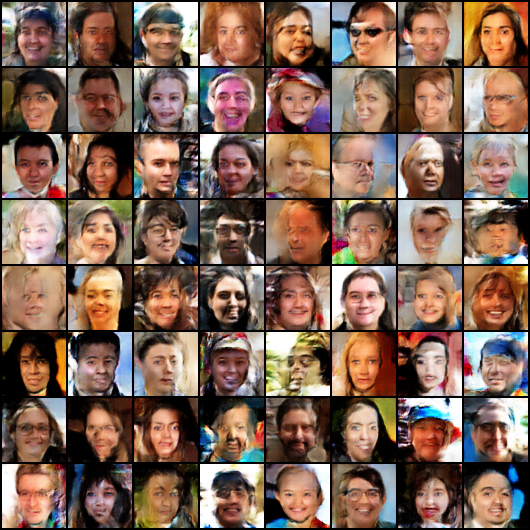

In [63]:
Image('./generated/generated-images-0010.png')

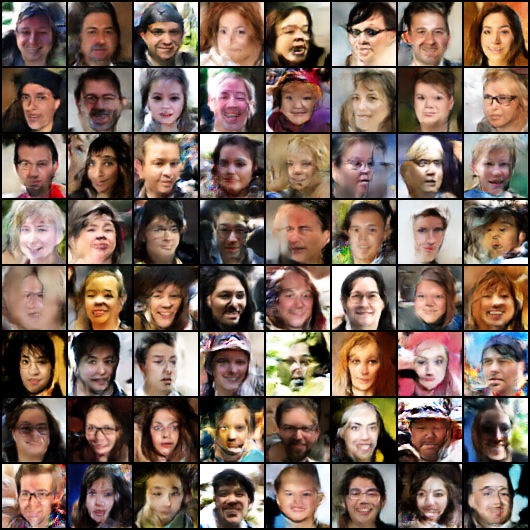

In [64]:
Image('./generated/generated-images-0015.png')

In [68]:
#Convert generated sample images into a video
vid_fname = 'imGAN-1.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [81]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

NameError: ignored

In [82]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

NameError: ignored